# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data
print('Documentos del corpus: ', len(newsgroupsdocs))

Documentos del corpus:  18846


In [3]:
print('Tipo del corpus cargado: ', type(newsgroupsdocs))

Tipo del corpus cargado:  <class 'list'>


In [4]:
# biblioteca para procesamiento de lenguaje natural
import nltk

# descargar las palabras en ingles para evitar terminos que no son palabras
nltk.download('words')
from nltk.corpus import words

# Diccionario de palabras reales en ingles
english_words = set(word.lower() for word in words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorizador Count para TF y DF
vectorizer = CountVectorizer(stop_words='english')
corpus_vect = vectorizer.fit_transform(newsgroupsdocs)

#Extraer los terminos del corpus
terms = vectorizer.get_feature_names_out()

In [6]:
import pandas as pd
import numpy as np

# Filtrar terminos que no son palabras reales del ingles
valid_idx = [i for i, t in enumerate(terms) if t.lower() in english_words]
filtered_terms = terms[valid_idx]
corpus_vect_filtered = corpus_vect[:, valid_idx]

# TF: ya esta en corpus_vect_filtered

# DF:
df = np.sum(corpus_vect_filtered > 0, axis=0).A1
df_df = pd.DataFrame({'term': filtered_terms, 'df': df})
df_df_sorted = df_df.sort_values(by='df', ascending=False)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(newsgroupsdocs)
tfidf_terms = tfidf_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_terms)
tfidf_means = df_tfidf.mean(axis=0).sort_values(ascending=False)

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [7]:
#similitud coseno
from sklearn.metrics.pairwise import cosine_similarity

#query a usarse
query = ['good coach']

#vectorizar la query
query_vec = tfidf_vectorizer.transform(query)
#calcular la similitud coseno de la query con cada documento
cos_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()

#10 documentos relevantes
top_k = 10
top_indices = cos_sim.argsort()[::-1][:top_k]

ranking_tfidf = pd.DataFrame({
    'doc_id': top_indices,
    'TF-IDF score': cos_sim[top_indices],
    'document': [newsgroupsdocs[i][:300].replace('\n', ' ') + "..." for i in top_indices]
})
print("\nRanking de documentos usando TF-IDF:")
print(ranking_tfidf)
for i in top_indices:
  print('------------------------------------------------------------')
  print(f'\t\t DOCUMENTO {i}')
  print('------------------------------------------------------------')
  print(newsgroupsdocs[i], '\n')
  print('------------------------------------------------------------\n')


Ranking de documentos usando TF-IDF:
   doc_id  TF-IDF score                                           document
0    9537      0.442227   : Bowman is the genius...Johnson isn't.  Bowm...
1    6665      0.420032                                    very good.  ...
2   10807      0.398066   The first time I heard this piece of news was...
3    3840      0.373128     All of this is fine.  I never said that Mur...
4   17776      0.343291   Bowman is in the Hockey Hall of Fame as a coa...
5   17520      0.324986   I would argue Gerald, that Bowman is the firs...
6   10525      0.304980     From his Topps "rookie" year (as coach) car...
7    7127      0.299129    Ah yes.  California.  Did the San Francisco ...
8    9968      0.282420        Considering how often and how badly he h...
9    9469      0.278857  I just overheard that San Jose Coach George Ki...
------------------------------------------------------------
		 DOCUMENTO 9537
----------------------------------------------------------

## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [8]:
#si no se tiene rank_bm25, se debe instalar
#pip install rank_bm25

In [9]:
#importar bm25 y minmaxscaler para normalizar los scores
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler

#preprocesar documentos para BM25 (tokenizar en minúsculas y filtrar por palabras reales)
tokenized_corpus = [
    [word.lower() for word in doc.split() if word.lower() in english_words]
    for doc in newsgroupsdocs
]
bm25 = BM25Okapi(tokenized_corpus)
query_tokens = [w.lower() for w in query[0].split() if w.lower() in english_words]
bm25_scores = bm25.get_scores(query_tokens)

#normalizar BM25 scores a [0, 1]
scaler = MinMaxScaler()
bm25_scores_norm = scaler.fit_transform(bm25_scores.reshape(-1, 1)).flatten()

top_bm25_idx = np.argsort(bm25_scores_norm)[::-1][:top_k]

ranking_bm25 = pd.DataFrame({
    'doc_id': top_bm25_idx,
    'BM25 score': [bm25_scores_norm[i] for i in top_bm25_idx],
    'document': [newsgroupsdocs[i][:300].replace('\n', ' ') + "..." for i in top_bm25_idx]
})
print("\nRanking de documentos usando BM25:")
print(ranking_bm25)

for i in top_bm25_idx:
  print('------------------------------------------------------------')
  print(f'\t\t DOCUMENTO {i}')
  print('------------------------------------------------------------')
  print(newsgroupsdocs[i], '\n')
  print('------------------------------------------------------------\n')


Ranking de documentos usando BM25:
   doc_id  BM25 score                                           document
0    7127    1.000000    Ah yes.  California.  Did the San Francisco ...
1   10807    0.974536   The first time I heard this piece of news was...
2    9469    0.966595  I just overheard that San Jose Coach George Ki...
3    3840    0.954767     All of this is fine.  I never said that Mur...
4    9537    0.943500   : Bowman is the genius...Johnson isn't.  Bowm...
5   17776    0.786928   Bowman is in the Hockey Hall of Fame as a coa...
6    4590    0.779894   *> *>McGill/Hammond -> Johan Garpenlov.  Woul...
7   10525    0.733365     From his Topps "rookie" year (as coach) car...
8    2040    0.703151    Wow.  So that's probably the reason why curr...
9    7142    0.698588    Markus had a good season in MoDo in the Swed...
------------------------------------------------------------
		 DOCUMENTO 7127
------------------------------------------------------------


Ah yes.  California

In [10]:
#DataFrame comparativo para los top_k índices únicos
#unión de índices TF-IDF y BM25
indices_union = list(set(top_indices).union(set(np.argsort(bm25_scores)[::-1][:top_k])))

comparativa_df = pd.DataFrame({
    'idDocs': indices_union,
    'BM25 Score': [bm25_scores_norm[i] for i in indices_union],
    'TF-IDF Score': [cos_sim[i] for i in indices_union]
})


comparativa_df

,idDocs,BM25 Score,TF-IDF Score
0,3840,0.954767,0.373128
1,9537,0.943500,0.442227
2,6665,0.000000,0.420032
3,7127,1.000000,0.299129
4,10525,0.733365,0.304980
5,7142,0.698588,0.109480
6,4590,0.779894,0.222376
7,17776,0.786928,0.343291
8,17520,0.690132,0.324986
9,9968,0.000000,0.282420


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?

- Todos los documentos presentados obtienen mayor puntaje en el modelo BM25. Los documentos que obtienen mayor puntaje en BM25 que en TF-IDF son los que tienen los siguientes id: 2040, 3840, 4590, 7127, 7142, 9469, 9537, 10525, 10807. 17520 y 17776.
4. Sugiere: ¿A qué se podría deber esta diferencia?
- Se podría deber a que BM25 no solo considera el íncice invertidom sino también considera la longitud de los documentos y acorde a su longitud calcula el score para cada término.

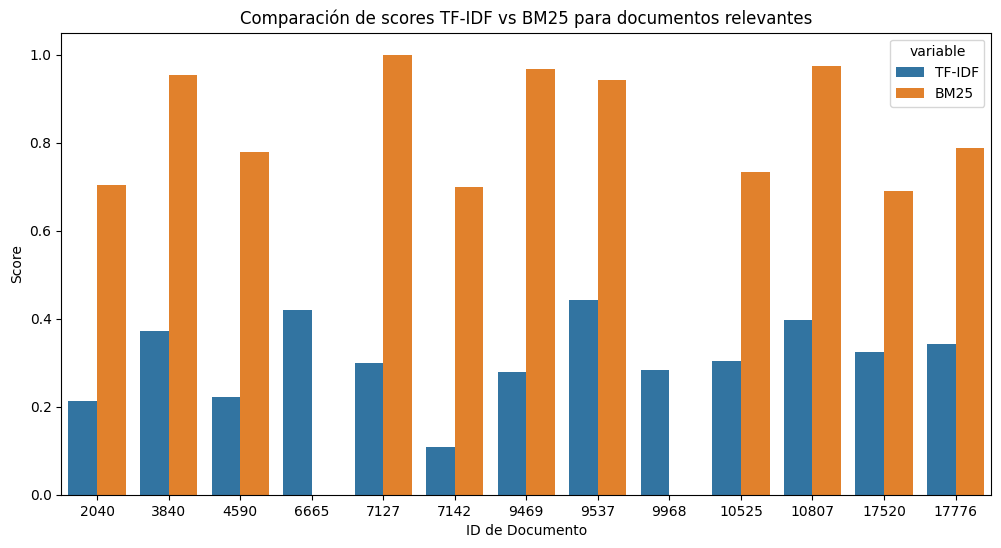

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Unir rankings
comparison_df = pd.DataFrame({
    'doc_id': list(set(top_indices) | set(top_bm25_idx))
})
comparison_df['TF-IDF'] = comparison_df['doc_id'].apply(lambda i: cos_sim[i])
comparison_df['BM25'] = comparison_df['doc_id'].apply(lambda i: bm25_scores_norm[i])

comparison_df = comparison_df.sort_values(by='BM25', ascending=False).reset_index(drop=True)

#ploteo de la grafica
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.melt(id_vars='doc_id', value_vars=['TF-IDF', 'BM25']),
            x='doc_id', y='value', hue='variable')
plt.title('Comparación de scores TF-IDF vs BM25 para documentos relevantes')
plt.xlabel('ID de Documento')
plt.ylabel('Score')
plt.show()

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
- La consulta que se elijió fue: good coach y los docuemntos relevantes se seleccionaron en base a la lectura de los documentos que TF-IDF y BM25 arrojaron.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?
Acorde a mi criterio de relevancia, el modelo que da mejores resultados fue TF-IDF. El resultado puede cambiar para otras querys y los docuemntos que se consideren relevantes para la query, ya que yo consideré los docuemntos relevantes acorde a la lectura y mi criterio sobre si aporta o no información relevante acorde a la query.

In [12]:
#índices de los documentos considerados relevantes
relevant_docs = {10807, 10525, 9537}

# Función para calcular Precision@k
def precision_at_k(ranking, relevant_docs, k=3):
    top_k = ranking[:k]
    relevantes_en_top_k = sum(1 for doc_id in top_k if doc_id in relevant_docs)
    return relevantes_en_top_k / k

# Función para calcular MAP
def average_precision(ranking, relevantes):
    hits = 0
    sum_precisions = 0
    for i, doc_id in enumerate(ranking):
        if doc_id in relevant_docs:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / len(relevant_docs) if relevant_docs else 0

# Aplica las métricas
# TF-IDF
precision_tfidf = precision_at_k(top_indices, relevant_docs, k=3)
map_tfidf = average_precision(top_indices, relevant_docs)

# BM25
precision_bm25 = precision_at_k(top_bm25_idx, relevant_docs, k=3)
map_bm25 = average_precision(top_bm25_idx, relevant_docs)

# resultados comparativos
print('\n---------- Evaluación de modelos ----------')
print(f'TF-IDF  -> Precision@3: {precision_tfidf:.2f} | MAP: {map_tfidf:.2f}')
print(f'BM25    -> Precision@3: {precision_bm25:.2f} | MAP: {map_bm25:.2f}')



---------- Evaluación de modelos ----------
TF-IDF  -> Precision@3: 0.67 | MAP: 0.70
BM25    -> Precision@3: 0.33 | MAP: 0.42
